## Summary of quiet Grosfeld cavity inversion test

Running idealised MOM6 ice shelf cavity with constant T=-1.9, S=34.4. Control directories are [here for the ice shelf](https://github.com/claireyung/mom6-isomip-control-2/tree/main/zstar_quiet_shelfon_modvisc) and [here for the inverted shelf topography](https://github.com/claireyung/mom6-isomip-control-2/tree/main/zstar_quiet_topoginv_modvisc).

Ice shelf is static and ice shelf thermodynamics is off.

Horizontal and vertical diffusivity is turned off. This was tested using a stratified box ocean (no ice shelf, flat topography), where we see that it doesn't move (velocities order 10^-12m/s). Thus, any velocities generated when adding an ice shelf are probably due to pressure gradient errors.

The configuration is the Grosfeld cavity ([Hunter, 2008](https://www.johnroberthunter.org/science/home_prof/reports/test_cavities.pdf )), consisting of a zonally uniform shelf with a sloped section leading to a flat section. We have one run with the ice shelf, and one with the ice shelf shape as the topography.

In this notebook we plot:
- snapshots after one year of simulation, showing the temperature, salinity and spurious velocities. 
- maximum horizontal speed as a function of time

We also ran this for different vertical coordinates, equations of state and stratifications but the comparison here best summarise the spurious velocities we are getting.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
base_folder = '/scratch/x77/cy8964/mom6/archive/'
list_folders = ['zstar_quiet_shelfon_modvisc/','zstar_quiet_topoginv_modvisc/']
names_runs =['zstar_quiet_shelfon','zstar_quiet_topoginv']

In [3]:
## define some useful functions

## open files from NCI storage
def open_files(i):
    base = base_folder + list_folders[i]
    prog = xr.open_dataset(base + '/output000/prog__0001_001.nc')
    ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_static = xr.open_dataset(base + "output000/ocean_static.nc")
    return prog, ocean_daily_z, ocean_static

## plot a transect of variable with given x section (xx0) and time (tt)
def plot(ax,xx0,tt,i,variable,varname,vmin1,vmax1,cmap):
    prog, ocean_daily_z, ocean_static = open_files(i)
    file_name = list_folders[i]
    label = names_runs[i]
    depth = prog.e
    lat = ocean_static.geolat
    dataplot = variable

    xx = lat
    if varname == "vo": dataplot = dataplot[:,:,:-1,:]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:-1,:,xx0]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[:,xx0], yi) #We repeat the horizontal part of the grid by the number of zlevels
    cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,:,xx0],levels = levels, cmap = cmap)
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(xh = 25)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    yh = prog.yh

    for i in range(nz):
        ax.plot(yh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-900,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_title(varname+' , ' +label)

# find horizontal speed
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2+vo_interp**2)
    return horiz_speed

# Generate xgcm grid object:
prog, ocean_daily_z, ocean_static = open_files(0)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)


In [4]:
no_configs = len(list_folders)

## Plot transect 

time = 0002-01-01 00:00:00


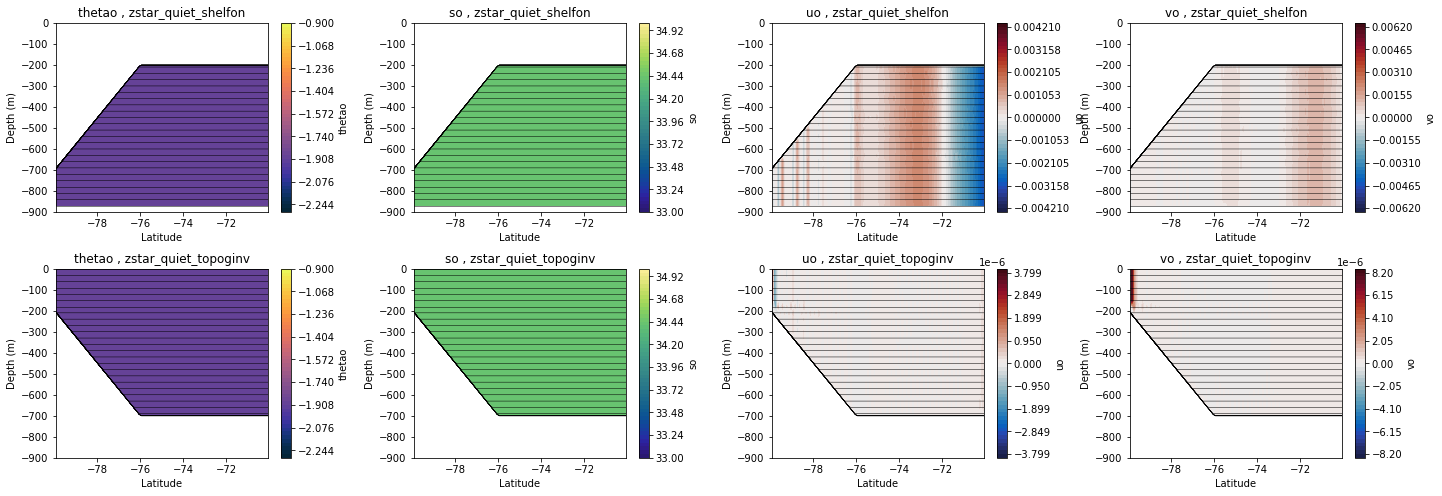

In [8]:
fig,axes = plt.subplots(nrows = no_configs, ncols = 4, figsize = (24,4*no_configs))
time = -1 ## 365 days
x = 25
for j in np.arange(no_configs):
    prog, ocean_daily_z, ocean_static = open_files(j)
    #plot temp
    plot(axes[j,0],x,time,j,prog.temp,"thetao",-2.3,-0.9,cm.cm.thermal)
    # plot salinity
    plot(axes[j,1],x,time,j,prog.salt,"so",33,35,cm.cm.haline)
    # plot u
    scale = np.abs(prog.isel(Time = time).u).max().values
    if scale < 1e-10: ## in case of very small number
        scale = 1e-10
    scale = scale
    plot(axes[j,2],x,time,j,prog.u,"uo",-scale,scale,cm.cm.balance)
    # plot v
    scale = np.abs(prog.isel(Time = time).v).max().values
    if scale < 1e-10: ## in case of very small number
        scale = 1e-10
    scale = scale
    plot(axes[j,3],x,time,j,prog.v,"vo",-scale,scale,cm.cm.balance)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

print('time = '+str(prog.isel(Time = time).Time.values))

**Note** the different colourbars of the velocity transects.

## Plot maximum horizontal speed

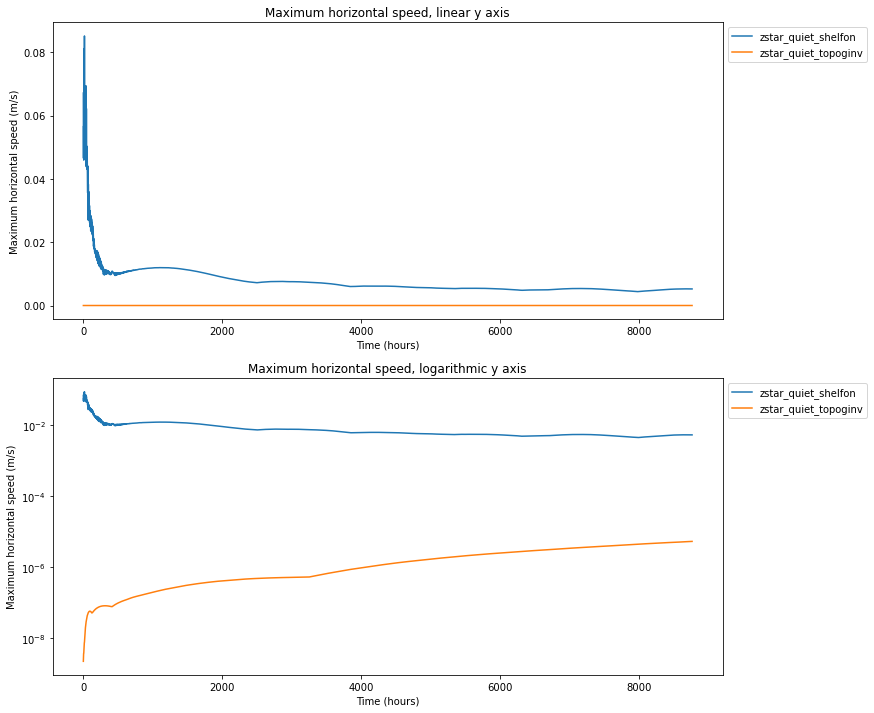

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,12))
linestyle = '-'
for j in np.arange(no_configs):
    prog, ocean_daily_z, ocean_static = open_files(j)
    label = names_runs[j]
    
    horiz_speed = find_speed(prog)
    Time = np.arange(365*12)*2+2
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    
axes[0].set_ylabel('Maximum horizontal speed (m/s)')
axes[0].set_xlabel('Time (hours)')
axes[0].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[0].set_title('Maximum horizontal speed, linear y axis')
axes[1].set_yscale('log')
axes[1].set_ylabel('Maximum horizontal speed (m/s)')
axes[1].set_xlabel('Time (hours)')
axes[1].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[1].set_title('Maximum horizontal speed, logarithmic y axis')

plt.show()



### Summary

- We are getting spurious velocities on the order of 1cm/s in the ice shelf case. These get larger with a nonlinear equation of state and stratification.
- We don't seem to have the same spurious velocities when the ice shelf geometry is implemented at the bottom of the ocean as topography